# Introduction

In this project, I will build up a four-layer fully connected neural network from scratch, including all the forward computation and backward propogation to update the network parameters.

We first import necessary packages,

In [20]:
import numpy as np 
import h5py
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

and define ReLu activation function, as well as its derivative.

In [21]:
# ReLu
def relu(x):
    x[x<0] = 0
    return x

# ReLu prime
def relu_p(x):
    x[x>0] = 1
    x[x<=0] = 0
    return x

Moreover, we consider normalization as data preprocessing such that the data has zero mean and unit variance.

In [22]:
def data_preprossing(X_train):
    scaler = preprocessing.StandardScaler().fit(X_train)     
    return scaler.transform(X_train)  

Now we start explaining the model configuration with 2 hidden layers. Specifically, the network structure is given in the following figure:

Input layer --> 1st hidden layer with $D_1$ number of neurons --> Batch Normalization layer --> ReLu activation layer --> 2nd hidden layer with $D_2$ number of neurons --> Batch Normalization layer --> ReLu activation layer --> Output layer. 

The weight of the model is initialized with Xavier method and updated according to a vanilla mini-batch SGD. Moreover, I make an option to allow the best model to be recorded.

![image.png](fig1.png)

In [23]:
# The source code of batch normalization is referred to https://deepnotes.io/batchnorm
class Batchnorm():
    
    # X_dim is the dimension of each data point, par is the tuple of learnable parameters [gamma, beta]
    def __init__(self,X_dim, par=None):
        self.params = par
        if self.params == None:
            self.gamma = np.ones((1, int(X_dim)))
            self.beta = np.zeros((1, int(X_dim)))
            self.params = [self.gamma,self.beta]

    def forward(self,X):
        self.n_X = X.shape[0]
        self.X_shape = X.shape
        
        self.X_flat = X.ravel().reshape(self.n_X,-1)
        self.mu = np.mean(self.X_flat,axis=0)
        self.var = np.var(self.X_flat, axis=0)
        self.X_norm = (self.X_flat - self.mu)/np.sqrt(self.var + 1e-8)
        out = self.gamma * self.X_norm + self.beta
        
        return out.reshape(self.X_shape)

    def backward(self,dout):

        dout = dout.ravel().reshape(dout.shape[0],-1)
        X_mu = self.X_flat - self.mu
        var_inv = 1./np.sqrt(self.var + 1e-8)
        
        dbeta = np.sum(dout,axis=0)
        dgamma = (dout * self.X_norm).sum(axis=0)

        dX_norm = dout * self.gamma
        dvar = np.sum(dX_norm * X_mu,axis=0) * -0.5 * (self.var + 1e-8)**(-3/2)
        dmu = np.sum(dX_norm * -var_inv ,axis=0) + dvar * 1/self.n_X * np.sum(-2.* X_mu, axis=0)
        dX = (dX_norm * var_inv) + (dmu / self.n_X) + (dvar * 2/self.n_X * X_mu)
        
        dX = dX.reshape(self.X_shape)
        return dX, dgamma, dbeta

In [41]:
class four_layers_model():
    
    # initialize the number of neurons in each hidden layer
    def __init__(self, hidden1_size, hidden2_size):
        self.hidden1_size = hidden1_size
        self.hidden2_size = hidden2_size
    
    # function to create a list containing mini-batches
    def create_mini_batches(self, X, Y, batch_size):
        mini_batches = []
        data = np.hstack((X, Y))
        np.random.shuffle(data)
        n_minibatches = data.shape[0] // batch_size

        for i in range(n_minibatches):
            mini_batch = data[i * batch_size:(i + 1)*batch_size, :]
            X_mini = mini_batch[:, :-1]
            Y_mini = mini_batch[:, -1].reshape((-1, 1))
            mini_batches.append((X_mini, Y_mini))
        if data.shape[0] % batch_size != 0:
            mini_batch = data[n_minibatches * batch_size:data.shape[0], :]
            X_mini = mini_batch[:, :-1]
            Y_mini = mini_batch[:, -1].reshape((-1, 1))
            mini_batches.append((X_mini, Y_mini))
        return mini_batches
    
    

    def train(self,X,Y,X_val,Y_val,epochs,h,batch_size,regulation,best_model=True, verbose=True):
        
        self.input_dim =  len(X.T)
        self.output_dim = len(Y.T)
        self.max_label = max(Y)
        self.min_label = min(Y)
        self.error_tolerance = regulation
        
        # store the result from each epoch
        self.accuracies = []
        self.losses = []
        self.val_accuracies = []
        self.val_losses = []
        
        # initialize the weight of each neuron with Xavier init
        np.random.seed(0)
        W1 = np.random.normal(loc=0.0, scale=(1/np.sqrt(len(X))),size=(self.input_dim, self.hidden1_size))
        b1 = np.zeros(shape=self.hidden1_size)
        W2 = np.random.normal(loc=0.0, scale=(1/np.sqrt(len(X))),size=(self.hidden1_size, self.hidden2_size))
        b2 = np.zeros(shape=self.hidden2_size)
        W3 = np.random.normal(loc=0.0, scale=(1/np.sqrt(len(X))),size=(self.hidden2_size, self.output_dim))
        b3 = np.zeros(shape=self.output_dim)    
        batchnorm1 = Batchnorm(self.hidden1_size)
        batchnorm2 = Batchnorm(self.hidden2_size)
        
        
        for i in range(epochs):

            mini_batches = self.create_mini_batches(X, Y, batch_size)
            for mini_batch in mini_batches:
                N = len(mini_batch[0])
                # compute the loss
                z1 = np.dot(mini_batch[0], W1) + b1     # [N x hidden1_size]
                c1 = batchnorm1.forward(z1)             # [N x hidden1_size]
                y1 = relu(c1)                           # [N x hidden1_size]
                z2 = np.dot(y1, W2) + b2                # [N x hidden2_size]
                c2 = batchnorm2.forward(z2)             # [N x hidden2_size]
                y2 = relu(c2)                           # [N x hidden2_size]
                z3 = np.dot(y2, W3) + b3                # [N x output_dim]
                r = z3 - mini_batch[1]                  # [N x output_dim]
                L = np.dot(r.T, r)/2.0                  # [1 x 1]

                #
                # backward pass
                #
                # partial derivatives
                dLdr = r                                                      # [N x output_dim]
                drdz3 = 1                                                     # [N x output_dim]
                dz3dW3 = y2                                                   # [N x hidden2_size]
                dz3db3 = np.ones(shape = N)                                   # [N, ]
                dz3dy2 = W3                                                   # [hidden2_size x output_dim]
                dy2dc2 = relu_p(c2)                                           # [N x hidden2_size]
                dc2dz2, dc2dgamma2, dc2dbeta2 = batchnorm2.backward(c2)       # [N x hidden2_size], [hidden2_size, ], [hidden2_size, ]
                dz2dW2 = y1                                                   # [N x hidden1_size]
                dz2db2 = np.ones(shape = N)                                   # [N, ]
                dz2dy1 = W2                                                   # [hidden1_size x hidden2_size]
                dy1dc1 = relu_p(c1)                                           # [N x hidden1_size]
                dc1dz1, dc1dgamma1, dc1dbeta1 = batchnorm1.backward(c1)       # [N x hidden1_size], [hidden1_size, ], [hidden1_size, ]
                dz1dW1 = mini_batch[0]                                        # [N x input_dim]
                dz1db1 = np.ones(shape = N)                                   # [N, ]
                                
                # chain rule
                dLdW3 = np.dot(dLdr.T, dz3dW3).T
                dLdb3 = np.dot(dLdr.T, dz3db3)
                dLdW2 = np.dot((np.dot(dLdr,dz3dy2.T)*dy2dc2*dc2dz2).T, dz2dW2).T                                         # dLdW2 = dLdr*drdz3*dz3dy2*dy2dc2*dc2dz2*dz2dW2
                dLdb2 = np.dot((np.dot(dLdr,dz3dy2.T)*dy2dc2*dc2dz2).T, dz2db2)                                           # dLdb2 = dLdr*drdz3*dz3dy2*dy2dc2*dc2dz2*dz2db2
                dLdW1 = np.dot((np.dot((np.dot(dLdr,dz3dy2.T)*dy2dc2*dc2dz2), dz2dy1.T)*dy1dc1*dc1dz1).T,dz1dW1).T        # dLdW1 = dLdr*drdz3*dz3dy2*dy2dc2*dc2dz2*dz2dy1*dy1dc1*dc1dz1*dz1dW1
                dLdb1 = np.dot((np.dot((np.dot(dLdr,dz3dy2.T)*dy2dc2*dc2dz2), dz2dy1.T)*dy1dc1*dc1dz1).T,dz1db1)          # dLdb1 = dLdr*drdz3*dz3dy2*dy2dc2*dc2dz2*dz2dy1*dy1dc1*dc1dz1*dz1db1
                dLdgamma2 = np.dot(np.dot(np.dot(dLdr,dz3dy2.T).T,dy2dc2), dc2dgamma2)                                    # dLdgamma2 = dLdr*drdz3*dz3dy2*dy2dc2*dc2dgamma2
                dLdbeta2 = np.dot(np.dot(np.dot(dLdr,dz3dy2.T).T,dy2dc2), dc2dbeta2)                                      # dLdbeta2 = dLdr*drdz3*dz3dy2*dy2dc2*dc2dbeta2
                dLdgamma1 = np.dot(np.dot(np.dot((np.dot(dLdr,dz3dy2.T)*dy2dc2*dc2dz2), dz2dy1.T).T,dy1dc1), dc1dgamma1)  # dLdgamma2 = dLdr*drdz3*dz3dy2*dy2dc2*dc2dz2*dz2dy1*dy1dc1*dc1dgamma1
                dLdbeta1 = np.dot(np.dot(np.dot((np.dot(dLdr,dz3dy2.T)*dy2dc2*dc2dz2), dz2dy1.T).T,dy1dc1), dc1dbeta1)    # dLdbeta2 = dLdr*drdz3*dz3dy2*dy2dc2*dc2dz2*dz2dy1*dy1dc1*dc1dbeta1
                
                # gradient update
                W3 = W3 - h*dLdW3
                b3 = b3 - h*dLdb3
                W2 = W2 - h*dLdW2
                b2 = b2 - h*dLdb2
                W1 = W1 - h*dLdW1
                b1 = b1 - h*dLdb1 
                batchnorm2.gamma = batchnorm2.gamma - h*dLdgamma2
                batchnorm2.beta = batchnorm2.beta - h*dLdbeta2
                batchnorm1.gamma = batchnorm1.gamma - h*dLdgamma1
                batchnorm1.beta = batchnorm1.beta - h*dLdbeta1
                batchnorm2.params = [batchnorm2.gamma, batchnorm2.beta]
                batchnorm1.params = [batchnorm1.gamma, batchnorm1.beta]
                
            # compute the loss in training
            z1 = np.dot(X, W1) + b1                 # [N x hidden1_size]
            c1 = batchnorm1.forward(z1)             # [N x hidden1_size]
            y1 = relu(c1)                           # [N x hidden1_size]
            z2 = np.dot(y1, W2) + b2                # [N x hidden2_size]
            c2 = batchnorm2.forward(z2)             # [N x hidden2_size]
            y2 = relu(c2)                           # [N x hidden2_size]
            z3 = np.dot(y2, W3) + b3                # [N x output_dim]
            r = z3 - Y                              # [N x output_dim]
            L = np.dot(r.T, r)/2.0                  # [1 x 1]
                
                
            # compute the loss in validation
            z1_val = np.dot(X_val, W1) + b1
            c1_val = batchnorm1.forward(z1_val)         
            y1_val = relu(c1_val)                           
            z2_val = np.dot(y1_val, W2) + b2   
            c2_val = batchnorm2.forward(z2_val)
            y2_val = relu(c2_val)                           
            z3_val = np.dot(y2_val, W3) + b3                
            r_val = z3_val - Y_val                          
            L_val = np.dot(r_val.T, r_val)/2.0              
            
            
            # save the best model
            if best_model:               
                if len(self.losses) == 0:
                    
                    self.saved_par = [W1, b1, W2, b2, W3, b3]
                    self.batchnorm_par = [batchnorm1.params, batchnorm2.params]
                    
                    # round the predictions to obtain class labels
                    predict = np.round(z3).clip(self.min_label, self.max_label)
                    predict_val = np.round(z3_val).clip(min(Y_val), max(Y_val))
                    
                    # compute the error
                    error = float(np.count_nonzero(predict-Y)) / float(len(X))
                    error_val = float(np.count_nonzero(predict_val-Y_val)) / float(len(X_val))

                    # store the accuracy
                    self.accuracies.append(1.0 - error)
                    self.val_accuracies.append(1.0 - error_val)

                    # store the loss
                    self.losses.append(np.squeeze(L))       
                    self.val_losses.append(np.squeeze(L_val)) 
                    
                elif self.losses[-1] > np.squeeze(L):
                    
                    self.saved_par = [W1, b1, W2, b2, W3, b3]
                    self.batchnorm_par = [batchnorm1.params, batchnorm2.params]
                                       
                    predict = np.round(z3).clip(self.min_label, self.max_label)
                    predict_val = np.round(z3_val).clip(min(Y_val), max(Y_val))
                    
                    error = float(np.count_nonzero(predict-Y)) / float(len(X))
                    error_val = float(np.count_nonzero(predict_val-Y_val)) / float(len(X_val))

                    self.accuracies.append(1.0 - error)
                    self.val_accuracies.append(1.0 - error_val)

                    self.losses.append(np.squeeze(L))       
                    self.val_losses.append(np.squeeze(L_val)) 
                    
                else:
                    [W1,b1,W2,b2,W3,b3] = self.saved_par
                    [batchnorm1.params, batchnorm2.params] = self.batchnorm_par
                    
                    self.accuracies.append(self.accuracies[-1])
                    self.val_accuracies.append(self.val_accuracies[-1])
                    self.losses.append(self.losses[-1])
                    self.val_losses.append(self.val_losses[-1]) 
            else:
                self.saved_par = [W1, b1, W2, b2, W3, b3]
                self.batchnorm_par = [batchnorm1.params, batchnorm2.params]
                
                predict = np.round(z3).clip(self.min_label, self.max_label)
                predict_val = np.round(z3_val).clip(min(Y_val), max(Y_val))

                error = float(np.count_nonzero(predict-Y)) / float(len(X))
                error_val = float(np.count_nonzero(predict_val-Y_val)) / float(len(X_val))

                self.accuracies.append(1.0 - error)
                self.val_accuracies.append(1.0 - error_val)

                self.losses.append(np.squeeze(L))       
                self.val_losses.append(np.squeeze(L_val))                 
                
        
            # print the training result of current epoch
            if verbose:
                print('Finishing epoch {}/{}: train loss: {}, train accuracy: {}, val accuracy: {}, lr: {}'.format(i+1,epochs,self.losses[-1],self.accuracies[-1],self.val_accuracies[-1],h))
            
                if self.losses[-1] < self.error_tolerance:
                    print('Training ends early when the error satisfies the regularization.')
                    break
                elif i == (epochs - 1):
                    print('Training ends.')
        
        return self.accuracies, self.losses, self.val_accuracies, [self.saved_par,self.batchnorm_par]
    
    def prediction(self,X_test):
        
        [W1,b1,W2,b2,W3,b3] = self.saved_par
        
        batchnorm1 = Batchnorm(self.hidden1_size)
        batchnorm2 = Batchnorm(self.hidden2_size) 
        [batchnorm1.gamma,batchnorm1.beta] = self.batchnorm_par[0]
        [batchnorm2.gamma,batchnorm2.beta] = self.batchnorm_par[1]
        
        
        # compute the loss in training
        z1 = np.dot(X_test, W1) + b1            # [N x neurons]
        c1 = batchnorm1.forward(z1)
        y1 = relu(c1)                           # [N x neurons]
        z2 = np.dot(y1, W2) + b2                # [N x neurons]
        c2 = batchnorm2.forward(z2)
        y2 = relu(c2)                           # [N x neurons]
        z3 = np.dot(y2, W3) + b3                # [N x output_dim]
        
        return np.round(z3).clip(self.min_label, self.max_label)
        

Parameter configuration. For this project, I use $50$ neurons in each of the two hidden layers. I choose batch size to be 150 and step size 1e-5. I train the network for 200 epochs.

In [25]:
np.random.seed(0)
epochs = 200 # total number of epochs
neurons_1 = 50 # number of neurons in the first hidden layer
neurons_2 = 50 # number of neurons in the second hidden layer
batch_size = 150 
h = 1e-5 # step size for parameter update

Read the face dataset used from my project 1 and 2. Here I have an option to use normalization to preprocess the data before training. Then, I split the training dataset into two parts: training data and validation data with proportion 4:1.

In [26]:
# Read dataset
with h5py.File('./dataset/train_dataset.h5', 'r') as file:
    data = np.array(file.get('data'))
    label = np.array(file.get('label'))
    X_train = data
    y_train = label
    
with h5py.File('./dataset/test_dataset.h5', 'r') as file:
    data = np.array(file.get('data'))
    label = np.array(file.get('label'))
    X_test = data
    y_test = label
    
is_data_prepossing = True
# Data Preprossing
if is_data_prepossing:
    X_train = data_preprossing(X_train)
    
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=66)

y_train = np.expand_dims(y_train, -1)
y_val = np.expand_dims(y_val, -1)
y_test = np.expand_dims(y_test, -1)
    
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(1500, 1200) (1500, 1) (500, 1200) (500, 1) (200, 1200) (200, 1)


# Step 1: First shot

I test the performance of my network and use data preprocessing. The best_model option is enabled and I choose learning rate to be 1e-5. I set regularization to be $0$ for now.

In [27]:
model = four_layers_model(neurons_1, neurons_2)

is_data_prepossing = True # set True if use data normalization
regularization = 0.0

# Read dataset
with h5py.File('./dataset/train_dataset.h5', 'r') as file:
    data = np.array(file.get('data'))
    label = np.array(file.get('label'))
    X_train = data
    y_train = label
    
with h5py.File('./dataset/test_dataset.h5', 'r') as file:
    data = np.array(file.get('data'))
    label = np.array(file.get('label'))
    X_test = data
    y_test = label
    
# Data Preprossing
if is_data_prepossing:
    X_train = data_preprossing(X_train)
    
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=66)

y_train = np.expand_dims(y_train, -1)
y_val = np.expand_dims(y_val, -1)
y_test = np.expand_dims(y_test, -1)

accuracies, losses, val_accuracies, par1 = model.train(X_train,y_train,X_val,y_val,epochs,h,batch_size,regularization,best_model=True)

Finishing epoch 1/200: train loss: 216.57389976366974, train accuracy: 0.5173333333333333, val accuracy: 0.45999999999999996, lr: 1e-05
Finishing epoch 2/200: train loss: 194.27900596855577, train accuracy: 0.5473333333333333, val accuracy: 0.512, lr: 1e-05
Finishing epoch 3/200: train loss: 188.71878954987613, train accuracy: 0.5793333333333333, val accuracy: 0.5640000000000001, lr: 1e-05
Finishing epoch 4/200: train loss: 185.46207412110158, train accuracy: 0.5886666666666667, val accuracy: 0.5760000000000001, lr: 1e-05
Finishing epoch 5/200: train loss: 182.41419241439118, train accuracy: 0.5986666666666667, val accuracy: 0.5920000000000001, lr: 1e-05
Finishing epoch 6/200: train loss: 179.74246260492905, train accuracy: 0.6106666666666667, val accuracy: 0.594, lr: 1e-05
Finishing epoch 7/200: train loss: 177.39452907852703, train accuracy: 0.622, val accuracy: 0.602, lr: 1e-05
Finishing epoch 8/200: train loss: 175.18870675840085, train accuracy: 0.6326666666666667, val accuracy: 0

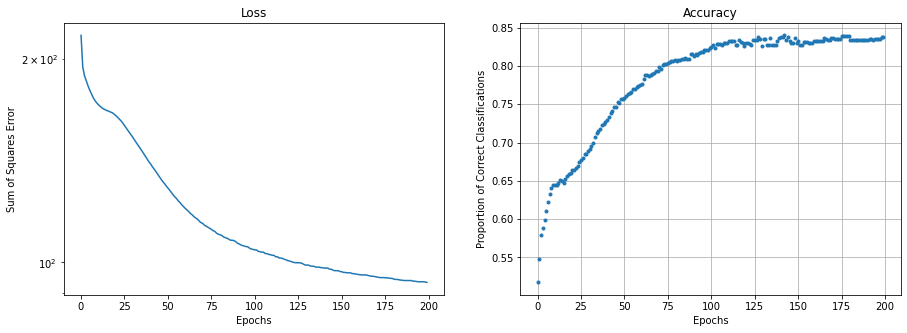

In [28]:
#Plot the loss and accuracy
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(121)
plt.semilogy(losses)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Sum of Squares Error')

ax = fig.add_subplot(122)
plt.plot(accuracies,'.')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Proportion of Correct Classifications')
#plt.ylim([0,1])
plt.grid()

plt.show()

# Step 2: Check model correctness

I crank up regularization to 1e2 to see if my model is setup properly.

In [29]:
model = four_layers_model(neurons_1, neurons_2)

is_data_prepossing = True # set True if use data normalization
regularization = 1e2

accuracies, losses, val_accuracies, par2 = model.train(X_train,y_train,X_val,y_val,epochs,h,batch_size,regularization,best_model=True)

Finishing epoch 1/200: train loss: 216.57389976366974, train accuracy: 0.5173333333333333, val accuracy: 0.45999999999999996, lr: 1e-05
Finishing epoch 2/200: train loss: 194.27900596855577, train accuracy: 0.5473333333333333, val accuracy: 0.512, lr: 1e-05
Finishing epoch 3/200: train loss: 188.71878954987613, train accuracy: 0.5793333333333333, val accuracy: 0.5640000000000001, lr: 1e-05
Finishing epoch 4/200: train loss: 185.46207412110158, train accuracy: 0.5886666666666667, val accuracy: 0.5760000000000001, lr: 1e-05
Finishing epoch 5/200: train loss: 182.41419241439118, train accuracy: 0.5986666666666667, val accuracy: 0.5920000000000001, lr: 1e-05
Finishing epoch 6/200: train loss: 179.74246260492905, train accuracy: 0.6106666666666667, val accuracy: 0.594, lr: 1e-05
Finishing epoch 7/200: train loss: 177.39452907852703, train accuracy: 0.622, val accuracy: 0.602, lr: 1e-05
Finishing epoch 8/200: train loss: 175.18870675840085, train accuracy: 0.6326666666666667, val accuracy: 0

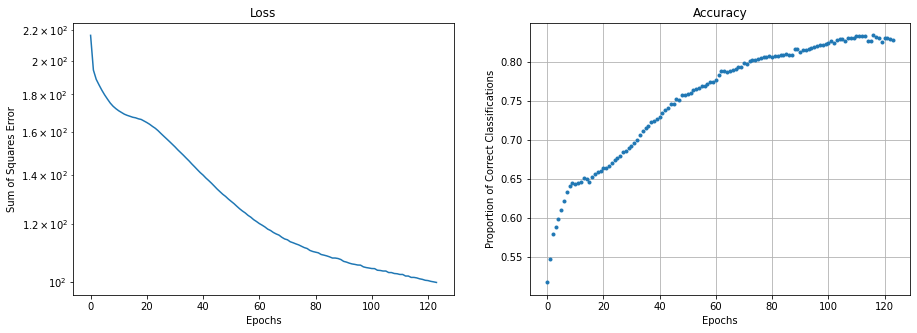

In [30]:
#Plot the loss and accuracy
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(121)
plt.semilogy(losses)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Sum of Squares Error')

ax = fig.add_subplot(122)
plt.plot(accuracies,'.')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Proportion of Correct Classifications')
#plt.ylim([0,1])
plt.grid()

plt.show()

We can see from above figure that the training process ends early when the error is below 1e2. This shows that my code works properly.

# Step 3: Test data normalization

I disabled the data preprocessing option and see how it affects the final training result.

In [31]:
model = four_layers_model(neurons_1, neurons_2)

is_data_prepossing = False # set True if use data normalization
regularization = 0.0

# Read dataset
with h5py.File('./dataset/train_dataset.h5', 'r') as file:
    data = np.array(file.get('data'))
    label = np.array(file.get('label'))
    X_train = data
    y_train = label
    
with h5py.File('./dataset/test_dataset.h5', 'r') as file:
    data = np.array(file.get('data'))
    label = np.array(file.get('label'))
    X_test = data
    y_test = label
    
# Data Preprossing
if is_data_prepossing:
    X_train = data_preprossing(X_train)
    
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=66)

y_train = np.expand_dims(y_train, -1)
y_val = np.expand_dims(y_val, -1)
y_test = np.expand_dims(y_test, -1)

accuracies, losses, val_accuracies, par3 = model.train(X_train,y_train,X_val,y_val,epochs,h,batch_size,regularization,best_model=True)

Finishing epoch 1/200: train loss: 214.10103167914815, train accuracy: 0.5226666666666666, val accuracy: 0.44799999999999995, lr: 1e-05
Finishing epoch 2/200: train loss: 190.99249775220562, train accuracy: 0.5553333333333333, val accuracy: 0.518, lr: 1e-05
Finishing epoch 3/200: train loss: 184.75835789133868, train accuracy: 0.5873333333333333, val accuracy: 0.562, lr: 1e-05
Finishing epoch 4/200: train loss: 180.97852829890655, train accuracy: 0.5973333333333333, val accuracy: 0.5820000000000001, lr: 1e-05
Finishing epoch 5/200: train loss: 177.53236630378018, train accuracy: 0.6133333333333333, val accuracy: 0.602, lr: 1e-05
Finishing epoch 6/200: train loss: 174.31016794643017, train accuracy: 0.6253333333333333, val accuracy: 0.612, lr: 1e-05
Finishing epoch 7/200: train loss: 171.4337756545761, train accuracy: 0.64, val accuracy: 0.62, lr: 1e-05
Finishing epoch 8/200: train loss: 168.54713106828328, train accuracy: 0.6526666666666667, val accuracy: 0.636, lr: 1e-05
Finishing epo

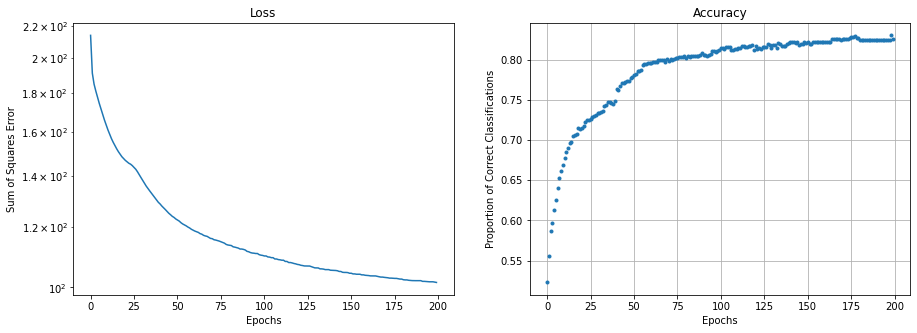

In [32]:
#Plot the loss and accuracy
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(121)
plt.semilogy(losses)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Sum of Squares Error')

ax = fig.add_subplot(122)
plt.plot(accuracies,'.')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Proportion of Correct Classifications')
#plt.ylim([0,1])
plt.grid()

plt.show()

As we can see from above two figures, disabling data normalization reduces the train accuracy from $83.8\%$ to $82.6\%$.

# Step 4: Test overfitting

Now we select a small portion of the training dataset (first $30$ data points) and see how it affects the validation accuracy.

In [33]:
model = four_layers_model(neurons_1, neurons_2)

is_data_prepossing = True # set True if use data normalization
regularization = 0.0

# Read dataset
with h5py.File('./dataset/train_dataset.h5', 'r') as file:
    data = np.array(file.get('data'))
    label = np.array(file.get('label'))
    X_train = data
    y_train = label
    
with h5py.File('./dataset/test_dataset.h5', 'r') as file:
    data = np.array(file.get('data'))
    label = np.array(file.get('label'))
    X_test = data
    y_test = label
    
# Data Preprossing
if is_data_prepossing:
    X_train = data_preprossing(X_train)
    
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=66)

y_train = np.expand_dims(y_train, -1)
y_val = np.expand_dims(y_val, -1)
y_test = np.expand_dims(y_test, -1)

h = 1e-4 # step size for parameter update

accuracies, losses, val_accuracies, par4 = model.train(X_train[:30],y_train[:30],X_val,y_val,epochs,h,batch_size,regularization,best_model=False)

Finishing epoch 1/200: train loss: 6.606461322562772, train accuracy: 0.6333333333333333, val accuracy: 0.492, lr: 0.0001
Finishing epoch 2/200: train loss: 6.378347927864325, train accuracy: 0.6, val accuracy: 0.522, lr: 0.0001
Finishing epoch 3/200: train loss: 6.245600158424419, train accuracy: 0.5333333333333333, val accuracy: 0.518, lr: 0.0001
Finishing epoch 4/200: train loss: 6.197518049125836, train accuracy: 0.5666666666666667, val accuracy: 0.52, lr: 0.0001
Finishing epoch 5/200: train loss: 6.164639110959747, train accuracy: 0.5, val accuracy: 0.522, lr: 0.0001
Finishing epoch 6/200: train loss: 6.162948835636403, train accuracy: 0.5333333333333333, val accuracy: 0.522, lr: 0.0001
Finishing epoch 7/200: train loss: 6.1380779155731675, train accuracy: 0.5, val accuracy: 0.526, lr: 0.0001
Finishing epoch 8/200: train loss: 6.171984553777369, train accuracy: 0.5, val accuracy: 0.52, lr: 0.0001
Finishing epoch 9/200: train loss: 6.2031588444661, train accuracy: 0.5, val accuracy

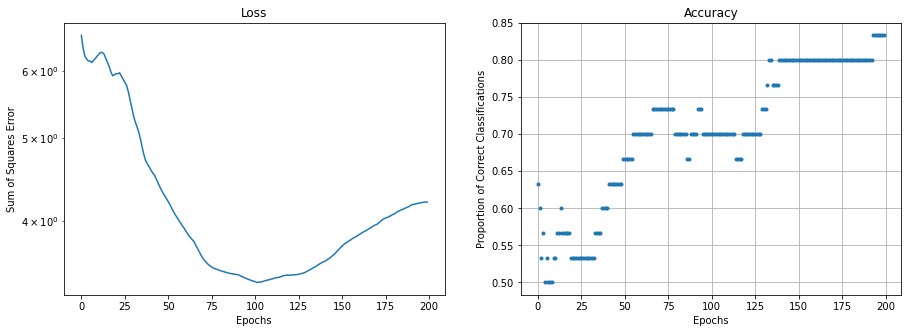

In [34]:
#Plot the loss and accuracy
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(121)
plt.semilogy(losses)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Sum of Squares Error')

ax = fig.add_subplot(122)
plt.plot(accuracies,'.')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Proportion of Correct Classifications')
#plt.ylim([0,1])
plt.grid()

plt.show()

As we can see in the above figures, when epochs go beyong 100, the loss rises again. Although we still get about $83\%$ train accuracy, the validation accuracy decreases from $81\%$ to $63.4\%$. This shows that the current network is overfitted to the current train dataset.

# Step 5: Hyperparameter tuning

In the previous steps, I use the step size 1e-5 by default and disable regularization. Now, I will train the network for 20 epochs so as to tune the step size and regularization to search for the suitable parameters.

In [35]:
is_data_prepossing = True # set True if use data normalization

# Read dataset
with h5py.File('./dataset/train_dataset.h5', 'r') as file:
    data = np.array(file.get('data'))
    label = np.array(file.get('label'))
    X_train = data
    y_train = label
    
with h5py.File('./dataset/test_dataset.h5', 'r') as file:
    data = np.array(file.get('data'))
    label = np.array(file.get('label'))
    X_test = data
    y_test = label
    
# Data Preprossing
if is_data_prepossing:
    X_train = data_preprossing(X_train)
    
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=66)

y_train = np.expand_dims(y_train, -1)
y_val = np.expand_dims(y_val, -1)
y_test = np.expand_dims(y_test, -1)



max_count = 100
model_save = []
epochs = 20 
neurons_1 = 50 
neurons_2 = 50 
batch_size = 150 

reg = 10**np.random.uniform(-5,0,max_count)
lr = 10**np.random.uniform(-3,-6,max_count)

for count in range(max_count):
    model = four_layers_model(neurons_1, neurons_2)
    accuracies, losses, val_accuracies, params = model.train(X_train,y_train,X_val,y_val,epochs,lr[count],batch_size,reg[count],best_model=True, verbose=False)
    model_save.append(params)
    print('Round {}/{}: val_acc: {}, lr: {}, reg: {}'.format((count+1),max_count,val_accuracies[-1],lr[count],reg[count]))
    
    

Round 1/100: val_acc: 0.612, lr: 0.00035335650584983975, reg: 0.0003001959544457955
Round 2/100: val_acc: 0.628, lr: 9.738534787767991e-06, reg: 7.384454987543527e-05
Round 3/100: val_acc: 0.604, lr: 3.388166935136662e-06, reg: 0.0006802243292630383
Round 4/100: val_acc: 0.772, lr: 0.00012233313919268827, reg: 0.01227918196709563
Round 5/100: val_acc: 0.622, lr: 6.5836468664911736e-06, reg: 2.1856525894297923e-05
Round 6/100: val_acc: 0.754, lr: 0.00014317888802358792, reg: 0.003596260401529178
Round 7/100: val_acc: 0.784, lr: 0.0002936028242368535, reg: 0.00022758326707296786
Round 8/100: val_acc: 0.778, lr: 9.450088038393e-05, reg: 0.14358065755405142
Round 9/100: val_acc: 0.69, lr: 0.000827813638330122, reg: 0.0001413342901721463
Round 10/100: val_acc: 0.752, lr: 0.0001819458408405684, reg: 0.004369829781345267
Round 11/100: val_acc: 0.63, lr: 5.006279286895316e-06, reg: 0.049446220272742765
Round 12/100: val_acc: 0.554, lr: 0.0005168887750422141, reg: 0.0016873909173678867
Round 13

Round 82 has the highest validation accuracy. Let's try the parameters: lr=0.0001, reg=1e-2

In [42]:
model = four_layers_model(neurons_1, neurons_2)

is_data_prepossing = True # set True if use data normalization
h = 1e-4
regularization = 2e-5
epochs = 200

# Read dataset
with h5py.File('./dataset/train_dataset.h5', 'r') as file:
    data = np.array(file.get('data'))
    label = np.array(file.get('label'))
    X_train = data
    y_train = label
    
with h5py.File('./dataset/test_dataset.h5', 'r') as file:
    data = np.array(file.get('data'))
    label = np.array(file.get('label'))
    X_test = data
    y_test = label
    
# Data Preprossing
if is_data_prepossing:
    X_train = data_preprossing(X_train)
    
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=66)

y_train = np.expand_dims(y_train, -1)
y_val = np.expand_dims(y_val, -1)
y_test = np.expand_dims(y_test, -1)

accuracies, losses, val_accuracies, par6 = model.train(X_train,y_train,X_val,y_val,epochs,h,batch_size,regularization,best_model=True)

Finishing epoch 1/200: train loss: 171.5503349666422, train accuracy: 0.64, val accuracy: 0.636, lr: 0.0001
Finishing epoch 2/200: train loss: 162.43645199549937, train accuracy: 0.6733333333333333, val accuracy: 0.646, lr: 0.0001
Finishing epoch 3/200: train loss: 153.3265041419426, train accuracy: 0.6926666666666667, val accuracy: 0.648, lr: 0.0001
Finishing epoch 4/200: train loss: 146.4081676097307, train accuracy: 0.7453333333333334, val accuracy: 0.732, lr: 0.0001
Finishing epoch 5/200: train loss: 131.2127421580758, train accuracy: 0.7586666666666666, val accuracy: 0.738, lr: 0.0001
Finishing epoch 6/200: train loss: 122.97786220764019, train accuracy: 0.7846666666666666, val accuracy: 0.776, lr: 0.0001
Finishing epoch 7/200: train loss: 120.87585245567026, train accuracy: 0.8093333333333333, val accuracy: 0.792, lr: 0.0001
Finishing epoch 8/200: train loss: 112.27422954176288, train accuracy: 0.7906666666666666, val accuracy: 0.732, lr: 0.0001
Finishing epoch 9/200: train loss:

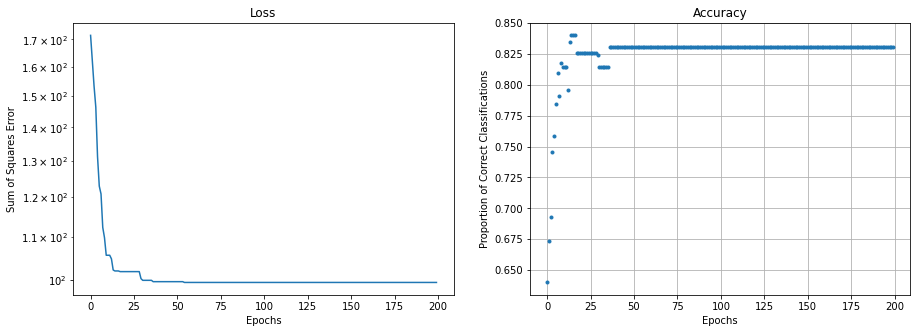

In [43]:
#Plot the loss and accuracy
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(121)
plt.semilogy(losses)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Sum of Squares Error')

ax = fig.add_subplot(122)
plt.plot(accuracies,'.')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Proportion of Correct Classifications')
#plt.ylim([0,1])
plt.grid()

plt.show()

As shown above, even though the validation accuracy of the parameter set (lr:1e-4, reg:1e-2) is worse than the initial parameter set (lr:1e-5, reg:0) used in step 1 part, which is $83\%$ vesus $83.8\%$, we can see the loss decreases much faster than the initial choice. The reason is that we have a larger learning rate. This means with smaller training epochs, we can quickly get the trained network with good performance. We further use test dataset to observe the accuracy can reach $80\%$.

In [44]:
predict = model.prediction(X_test) 
error = float(np.count_nonzero(predict-y_test)) / float(len(X_test))
accuracy = 1.0 - error
print('The test accuracy: {}'.format(accuracy))

The test accuracy: 0.8
